# Testing the multilabel model

*   Multilabel Image Classification. 6 classes are: bright, dark, good, lens flare, loss and motion blur.

In [4]:
from keras.utils.np_utils import to_categorical

In [5]:
import os
classes = os.listdir('data/test')

In [6]:
from keras.preprocessing.image import ImageDataGenerator
img_gen = ImageDataGenerator(validation_split=0.0)

In [7]:
# pip install tensorflow_hub

In [8]:
import tensorflow as tf
import tensorflow_hub as hub

inceptionV3_model = tf.keras.Sequential([
    hub.KerasLayer("inceptionV3_model")
])
inceptionV3_model.build([None, 224, 224, 3])

In [9]:
inceptionV3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6)                 21815078  
                                                                 
Total params: 21,815,078
Trainable params: 0
Non-trainable params: 21,815,078
_________________________________________________________________


In [10]:
test_data = img_gen.flow_from_directory(
    'data/test/',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
)

n_test_samples = len(test_data.filenames)
num_classes = len(test_data.class_indices)

test_labels = test_data.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 600 images belonging to 6 classes.


In [11]:
# inceptionV3_model.evaluate(tf.data.Dataset.from_tensor_slices((test_data, test_labels)))

In [13]:
import numpy as np
print('test data', test_data)
preds = np.round(inceptionV3_model.predict(test_data), 0) 

test data <keras.preprocessing.image.DirectoryIterator object at 0x000002AC2BE1F760>
19/19 [==============================] - 9s 399ms/step


#### Confusion matrix

In [16]:
import pandas as pd
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(categorical_test_labels, categorical_preds)

In [18]:
import itertools
from matplotlib import pyplot as plt
import seaborn as sns

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


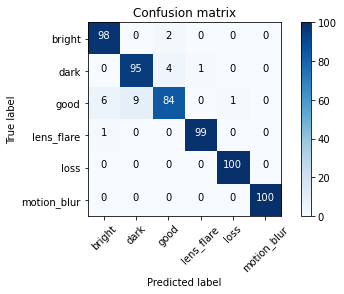

In [19]:
plot_confusion_matrix(confusion_matrix, classes)

Normalized confusion matrix


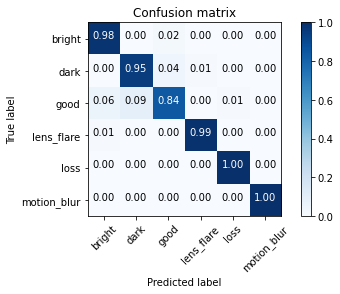

In [20]:
#Those numbers are all over the place. Now turning normalize = True
plot_confusion_matrix(confusion_matrix, classes, normalize=True)

#### Classification report

In [21]:
from sklearn import metrics
classification_metrics = metrics.classification_report(test_labels, preds, target_names=classes)
print(classification_metrics)

              precision    recall  f1-score   support

      bright       0.95      0.98      0.97       100
        dark       0.91      0.95      0.93       100
        good       0.93      0.84      0.88       100
  lens_flare       0.99      0.99      0.99       100
        loss       0.99      1.00      1.00       100
 motion_blur       1.00      1.00      1.00       100

   micro avg       0.96      0.96      0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600
 samples avg       0.96      0.96      0.96       600



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Evaluating samples of test data

In [22]:
from tensorflow.keras.utils import img_to_array, load_img

In [23]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    # image /= 255.  
    return image

In [24]:
def test_single_image(path):
    images = read_image(path)
    preds = inceptionV3_model.predict(images)
    for idx, layer, x in zip(range(0,6), classes , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, layer, np.round(x*100,2) ))
    print('Final Decision:')
    for x in range(3):
        print('.'*(x+1))
    class_predicted = np.argmax(preds, axis=1)
    class_dictionary = test_data.class_indices
    inv_map = {v: k for k, v in class_dictionary.items()} 
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))
    return load_img(path)

In [25]:
path = 'single images for testing/4.jpg'

In [40]:
path = 'organic mixed (good and bad)/1.jpg'

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 33ms/step
ID: 0, Label: bright 0.04%
ID: 1, Label: dark 92.76%
ID: 2, Label: good 7.18%
ID: 3, Label: lens_flare 0.0%
ID: 4, Label: loss 0.02%
ID: 5, Label: motion_blur 0.0%
Final Decision:
.
..
...
ID: 1, Label: dark


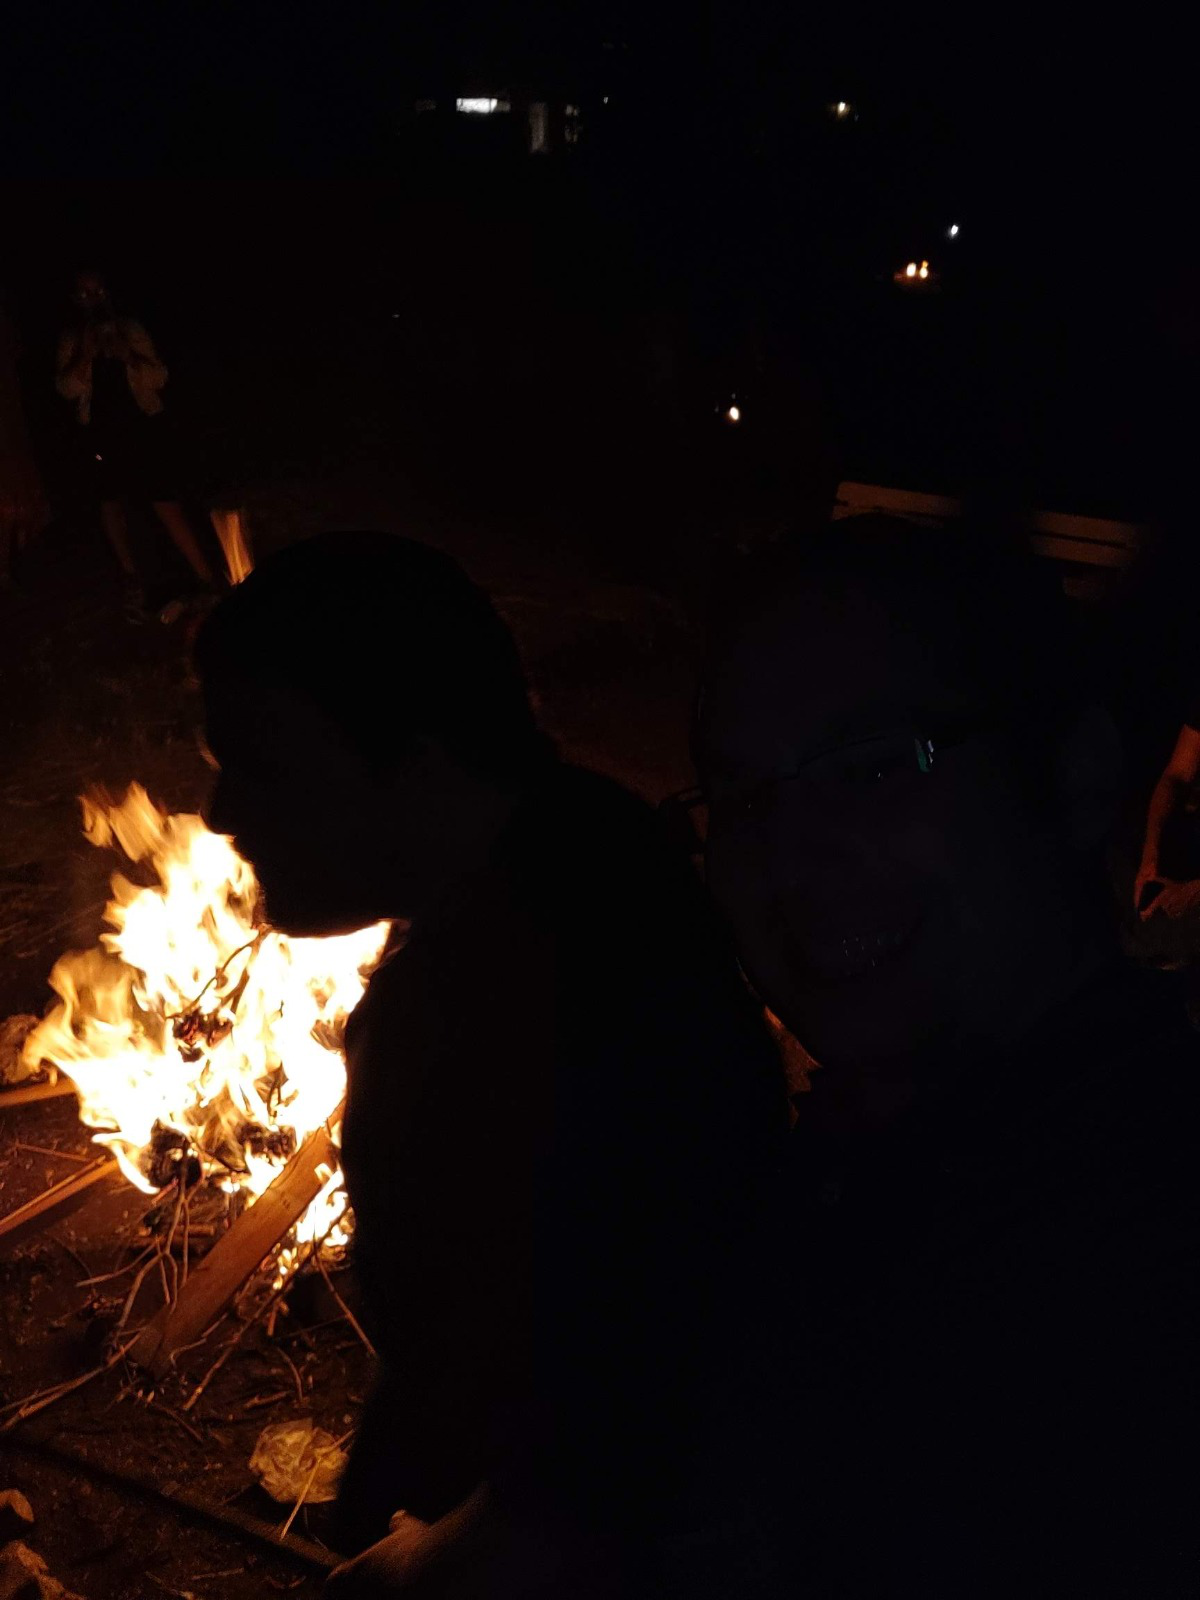

In [41]:
test_single_image(path)